# Setup

As a starting point, we will install the required packages and load a set of helper functions to assist throughout this tutorial. To keep the output clean and focused on interpretation, we will also suppress warnings.

Moreover, we provide helper functions that can be inspected directly in the `.py` files located in the notebook’s current directory. The three additional helper scripts are:
- `config.py`: Defines the base configuration settings, which can be overridden using a custom `.yml` file.
- `parsing.py`: Contains utilities to compile evaluation results from the training process.
- `preprocess.py`: Handles phenotype preprocessing (e.g., imputing missing values and encoding categorical variables) and feature extraction from the fMRI time series.

In [ ]:
import os
import warnings

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

## Packages

The main packages required for this tutorial are PyKale and Nilearn.

**PyKale** is an open-source interdisciplinary machine learning library developed at the University of Sheffield, with a focus on applications in biomedical and scientific domains.

**Nilearn** is a Python library for neuroimaging analysis, widely used for processing and visualizing functional MRI (fMRI) data.

In [ ]:
!pip install --quiet git+https://github.com/pykale/pykale@main nilearn \
    && echo "PyKale and Nilearn installed successfully ✅" \
    || echo "Failed to install PyKale and Nilearn ❌"

PyKale and Nilearn installed successfully ✅


## Configuration

To minimize the footprint of the notebook when specifying configurations, we provide a `config.py` file that defines default parameters. These can be customized by supplying a `.yml` configuration file, such as `experiments/base.yml` as an example.

In [ ]:
from config import get_cfg_defaults

cfg = get_cfg_defaults()
cfg.merge_from_file("experiments/base.yaml")
cfg.freeze()
print(cfg)

CONNECTIVITY:
  MEASURES: ['pearson']
CROSS_VALIDATION:
  NUM_FOLDS: 1
  NUM_REPEATS: 1
  SPLIT: lpgo
DATASET:
  ATLAS: aal
  BANDPASS: False
  GLOBAL_SIGNAL_REGRESSION: False
  PATH: nilearn_data
  QUALITY_CHECKED: False
PHENOTYPE:
  STANDARDIZE: site
RANDOM_STATE: 0
TRAINER:
  CLASSIFIER: lr
  NONLINEAR: False
  NUM_SEARCH_ITER: 100
  NUM_SOLVER_ITER: 1000000
  N_JOBS: -4
  REFIT: accuracy
  SCORING: ['accuracy', 'roc_auc']
  SEARCH_STRATEGY: random
  VERBOSE: 1


# Data Loading and Preprocessing

Typically, raw fMRI scans require extensive preprocessing before they can be used in a machine learning pipeline. However, the **ABIDE** dataset provides several preprocessed derivatives, which can be downloaded directly from the [Preprocessed Connectomes Project (PCP)](https://preprocessed-connectomes-project.org/abide/), eliminating the need for manual preprocessing.

In this tutorial, we focus on the following preprocessing options:
- `atlas`: The **brain atlas** used to **extract ROI time series**. Available options include: `"aal"`, `"cc200"`, `"cc400"`, `"dosenbach160"`, `"ez"`, `"ho"`, and `"tt"`. Default: `"aal"`
- `bp`: Whether to apply **band-pass filter** to the time series between [0.01, 0.1] Hz. Default: `False`
- `gsr`: Whether to apply **global signal regression** to remove shared global noise from the signals. Default: `False`
- `qc`: Whether to include **only scans that passed all quality checks** provided by the dataset curators. Default: `True`

In [ ]:
from nilearn.datasets import fetch_abide_pcp


# Fetch the preprocessed ABIDE dataset using the specified preprocessing options
# This returns a dictionary containing region-wise time series and associated metadata
dataset = fetch_abide_pcp(
    # Select the atlas-specific ROI time series (e.g., 'rois_aal')
    derivatives=[f"rois_{cfg.DATASET.ATLAS}"],
    # Whether to apply band-pass filtering
    band_pass_filtering=cfg.DATASET.BANDPASS,
    # Whether to apply global signal regression
    global_signal_regression=cfg.DATASET.GLOBAL_SIGNAL_REGRESSION,
    # Whether to include only subjects that passed QC
    quality_checked=cfg.DATASET.QUALITY_CHECKED,
)

time_series = dataset[f"rois_{cfg.DATASET.ATLAS}"]

[get_dataset_dir] Dataset found in /home/zarizky/nilearn_data/ABIDE_pcp


## Phenotype Preprocessing 

The phenotypic information in the dataset contains several missing values. We impute and encode it to make it suitable for modeling.

**Categorical Variables**

The following categorical phenotypes are used and will be **one-hot encoded**:
- `SITE_ID`
- `SEX`
- `HANDEDNESS_CATEGORY`
- `EYE_STATUS_AT_SCAN`

**Continuous Variables**

The following continuous phenotypes will optionally be **standardized**:
- `AGE_AT_SCAN`
- `FIQ`

Possible options to `standardize` the continuous phenotypes includes:
- `"all"` or `True`: Standardize across all subjects
- `"site"`: Standardize within each site
- `False`: No standardization

**Handling Missing Values**
- `HANDEDNESS_CATEGORY`: Missing values are assumed to correspond to `right-handed` subjects.
- `FIQ`: Missing values are imputed with a default score of `100`.

**Label Encoding**

The diagnostic label `DX_GROUP` is used to assign the target class:
- `CONTROL` → `0`
- `ASD` → `1`

In [ ]:
from preprocess import process_phenotypic_data

# Standardize continuous phenotypes (e.g., age, FIQ) within each site
standardize = "site"

# Process the phenotypic metadata from the ABIDE dataset
# This function handles:
# - Imputation of missing values (e.g., assuming right-handed for missing handedness)
# - One-hot encoding of categorical variables (e.g., sex, site, eye status)
# - Standardization of continuous variables based on the chosen strategy ('site' or 'all')

# Returns:
# - `labels`: Binary class labels (0 = control, 1 = ASD)
# - `sites`: Site identifiers for domain adaptation
# - `phenotypes`: Feature matrix containing encoded and standardized phenotypic variables
labels, sites, phenotypes = process_phenotypic_data(dataset["phenotypic"], standardize)

## Feature Extraction

Functional MRI (fMRI) time series data often vary in temporal length. However, many machine learning models, including those used in this study require fixed-size input. To address this, a common approach in fMRI analysis is to compute the functional connectivity (e.g., correlation) between regions of interest (ROIs), resulting in a fixed-size feature representation.

Specifically, we compute a connectivity matrix for each subject, and extract the upper or lower triangular part (excluding the diagonal) to obtain a feature vector suitable for model training.

The available arguments for feature extraction are:
- `measures`: A sequence of connectivity transformations applied to the ROI time series. Supported options include: `"pearson"`, `"partial"`, `"tangent"`, `"covariance"`, and `"precision"`. Default: `["pearson"]`.

Multiple transformations can be chained to compute composite connectivity representations. For example, the **Tangent-Pearson** method proposed by *Kunda et al.* can be specified via `measures = ["tangent", "pearson"]`. This design also allows for future extensions to support higher-order connectivity features.

```{warning}
Given the long runtime needed for Tangent-Pearson, we opt to use `"pearson"` by default.
```

In [ ]:
from preprocess import extract_functional_connectivity

features = extract_functional_connectivity(time_series, cfg.CONNECTIVITY.MEASURES)

# Modeling

We define and train machine learning models for classifying autism spectrum disorder (ASD) using functional connectivity features.

We explore different configurations including a baseline model, domain adaptation using site information, and an extended approach that incorporates additional phenotypic variables.

Each model is evaluated using cross-validation, and we analyze the impact of domain adaptation on classification performance.

### Random Seed

To ensure reproducibility across runs, we define a fixed random seed. This guarantees that all operations involving randomness, such as cross-validation splits, model initialization, and hyperparameter search to produce consistent results.

In [ ]:
from sklearn.utils.validation import check_random_state


# Convert the seed into a numpy-compatible RandomState instance
# This ensures consistent behavior across scikit-learn functions that rely on randomness
random_state = check_random_state(cfg.RANDOM_STATE)

### Cross-Validation Split

To evaluate model performance reliably, we define a cross-validation (CV) strategy. By default, we use **Repeated Stratified K-Fold**, which preserves class distribution across folds and supports repeated trials for more stable estimates.

Alternatively, we can also use **Leave-P-Groups-Out (LPGO)** cross-validation. This strategy is particularly useful in multi-site studies, as it ensures that data from the same group (e.g., imaging site) are not shared between training and test sets, enabling more realistic generalization assessment under domain shift.

For this tutorial we will specify several arguments:
- `split`: Defines the cross-validation strategy. `"skf"` for stratified k-fold to maintain label balance in each fold or use `"lpgo"` to evaluate generalization across sites by holding out entire groups (e.g., imaging sites). Default: `"lpgo"`
- `num_folds`: Sets how many folds to use for stratified k-fold or how many groups to leave out in LPGO. Default: `1`
- `num_cv_repeats`: Determines how many times the k-fold procedure is repeated to obtain more stable estimates (ignored when using LPGO). Default: `1`

In [ ]:
from sklearn.model_selection import LeavePGroupsOut, RepeatedStratifiedKFold

# Define the default cross-validation strategy:
# Repeated stratified k-fold maintains class distribution across folds and supports multiple repetitions
cv = RepeatedStratifiedKFold(
    # Number of stratified folds
    n_splits=cfg.CROSS_VALIDATION.NUM_FOLDS,
    # Number of repeat rounds
    n_repeats=cfg.CROSS_VALIDATION.NUM_REPEATS,
    # Ensures reproducibility
    random_state=random_state,
)

# Override with leave-p-proups-out if specified
# This strategy holds out `p` unique groups (e.g., sites) per fold, enabling group-level generalization
if cfg.CROSS_VALIDATION.SPLIT == "lpgo":
    # Use group-based CV for domain adaptation or site bias evaluation
    cv = LeavePGroupsOut(cfg.CROSS_VALIDATION.NUM_FOLDS)

### Model Definition
We define different model configurations used for classification. Each model shares the same base classifier (e.g., logistic regression), but differs in how domain adaptation is applied:
- **Baseline**: A standard model trained directly on functional connectivity features without domain adaptation.
- **Site Only**: A domain-adapted model that uses site labels as the adaptation factor, reducing site-specific bias.
- **All Phenotypes**: An extended domain-adapted model that incorporates multiple phenotypic variables (e.g., age, sex, handedness) to further reduce inter-site variability.

We also specify the hyperparameter search strategy and other training parameters for each configuration, including:
- `classifier`: The base model to use for classification. Available options include `"logistic"` for logistic regression, `"ridge"` for ridge classifier, and `"svm"` for support vector machines. Default: `"logistic"`
- `scoring`: A list of performance metrics (e.g., accuracy, F1, AUROC) used during cross-validation.
- `num_solver_iterations`: Maximum number of iterations allowed for the solver to converge during model fitting.
- `num_search_iterations`: Number of hyperparameter combinations to evaluate in a randomized search.
- `num_jobs`: Number of CPU cores used in parallel for hyperparameter tuning and model training. Set to `-1` to use all of the available CPU cores or `-k` to use all but `k` CPU cores.
- `verbose`: Controls the verbosity of the training output. Higher values provide more detailed logs.

In [ ]:
from sklearn.base import clone
from kale.pipeline.mida_trainer import AutoMIDAClassificationTrainer as Trainer


# Configuration with cv included
trainer_cfg = {k.lower(): v for k, v in cfg.TRAINER.items()}
trainer_cfg = {**trainer_cfg, "cv": cv}

# Initialize dictionary for different trainers
trainers = {}

# Create a baseline trainer without domain adaptation (MIDA disabled)
trainers["baseline"] = Trainer(use_mida=False, **trainer_cfg)

# Create a trainer with MIDA enabled, using site labels as domain adaptation factors
trainers["site_only"] = Trainer(use_mida=True, **trainer_cfg)

# Clone the 'site_only' trainer to create 'all_phenotypes' trainer
# This enables reusing the same training configuration, while modifying only the input domain factors
trainers["all_phenotypes"] = clone(trainers["site_only"])

# Cross-Validation

We train each model configuration using the previously defined cross-validation strategy. The training process involves fitting the model on functional connectivity features and evaluating its performance using multiple scoring metrics (e.g., accuracy, F1-score, AUROC).

For models with domain adaptation, we pass additional domain factors (such as site or phenotypic variables) to guide the alignment of feature representations. Cross-validation is performed to ensure robust performance estimates and to select the best hyperparameter configuration for each model.

In [ ]:
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
from tqdm import tqdm

# Define common training arguments for all models: features (X), labels (y), and group info (sites)
fit_args = {"x": features, "y": labels, "groups": sites}

cv_results = {}
for model in (pbar := tqdm(trainers)):
    args = clone(fit_args, safe=False)
    if model == "site_only":
        args["factors"] = LabelBinarizer().fit_transform(sites)
    elif model == "all_phenotypes":
        args["factors"] = phenotypes

    pbar.set_description(f"Fitting {model} model")
    trainers[model].fit(**args)
    cv_results[model] = pd.DataFrame(trainers[model].cv_results_)

Fitting all_phenotypes model: 100%|██████████████████████████████████████████████████| 3/3 [40:08<00:00, 802.99s/it]


# Evaluation

We evaluate and compare the performance of different model configurations using cross-validation results. We aggregate the top-performing scores for each model based on a specified evaluation metric (e.g., accuracy), allowing us to assess the effectiveness of domain adaptation strategies.

By comparing models with and without domain adaptation, we can determine the impact of incorporating site and phenotypic information on multi-site autism classification performance. This analysis helps identify which configurations generalize best across heterogeneous imaging sites.

In [ ]:
from parsing import compile_results

# Compile the cross-validation results into a summary table,
# sorting by the model with the highest test accuracy across CV folds
compiled_results = compile_results(cv_results, "accuracy")

# Display the compiled results DataFrame (models as rows, metrics as formatted strings)
display(compiled_results)

,Accuracy,AUROC
Model,,
Baseline,0.6658 ± 0.0852,0.7157 ± 0.1028
Site Only,0.6692 ± 0.1000,0.7057 ± 0.0944
All Phenotypes,0.6638 ± 0.0769,0.7140 ± 0.0871


# Interpretation

We interpret the trained models by analyzing the learned weights associated with functional connectivity features. Specifically, we extract the top-weighted ROI pairs that contributed most to the classification decision.

These weights are visualized as a **connectome plot**, allowing us to examine which brain region interactions are most informative for distinguishing individuals with autism from controls. This not only enhances the interpretability of the model but also provides potential insights into neurobiological patterns relevant to autism.

[get_dataset_dir] Dataset found in /home/zarizky/nilearn_data/aal_SPM12


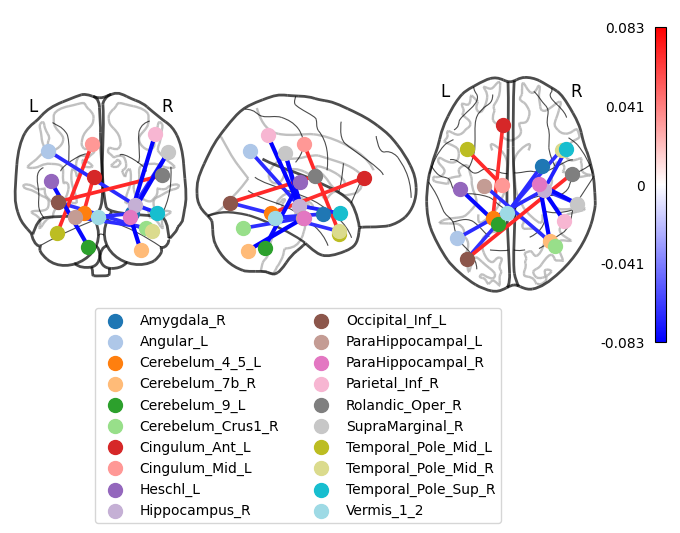

In [ ]:
import seaborn as sns
from nilearn.plotting import find_parcellation_cut_coords
from kale.interpret.visualize import visualize_connectome
from nilearn.datasets import fetch_atlas_aal

aal = fetch_atlas_aal()
coords = find_parcellation_cut_coords(aal.maps)
labels = aal.labels

proj = visualize_connectome(
    trainers["baseline"].coef_.ravel(),
    labels,
    coords,
    0.002,
    legend_params={
        "bbox_to_anchor": (2.75, -0.1),
        "ncol": 2,
    },
)

# Display the resulting connectome plot
display(proj)

This plot shows the **most discriminative ROI connections** for classifying ASD vs Control subjects.
- **Red edges** indicate connections **stronger in ASD**.
- **Blue edges** indicate connections **stronger in Control**.
- Color intensity reflects the **magnitude of contribution** to the model’s decision.

---

**Key Patterns**:
- **Cingulate Cortex**:
    - *Cingulum_Ant_L*, *Cingulum_Mid_L*
    - Central to **emotional regulation** and default mode network (DMN) activity, often disrupted in ASD.
- **Temporal Poles**:
    - *Temporal_Pole_Mid_L*, *Temporal_Pole_Mid_R*, *Temporal_Pole_Sup_R*
    - Involved in **social cognition**, **language**, and **emotion processing**, key deficits in ASD.
- **Cerebellum Subregions**:
    - *Cerebellum_7b_R*, *Cerebellum_9_L*, *Cerebellum_Crus1_R*
    - Linked to **motor control**, **timing**, and increasingly, to **higher-order cognition** in ASD studies.
- **Limbic and Memory-related Areas**:
    - *Hippocampus_R*, *ParaHippocampal_L/R*, *Amygdala_R*
    - Frequently show **altered volume and connectivity** in ASD, affecting memory, learning, and emotion.
- **Sensory and Integration Regions**:
    - *Heschl_L*, *Rolandic_Oper_R*, *Supramarginal_R*
    - Implicated in **auditory** and **sensorimotor integration**, which are commonly atypical in ASD.
- **Occipital and Parietal Areas**:
    - *Occipital_Inf_L*, *Parietal_Inf_R*
    - Linked to **visual processing** and **attention control**, where ASD differences have been reported.

The interpretability analysis of the trained model reveals that **functional connectivity differences across key brain regions** contribute meaningfully to distinguishing **ASD** from **Control** subjects.